In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.ticker import FormatStrFormatter

# Gráficos resultados

In [ ]:
def load_results(top_k, metric, dataset):
    df = pd.read_csv(f"surprise_kfold_k=5_{dataset}_top-{top_k}.csv", index_col=0)
    df_cleaned = df.map(lambda x: float(x.split('/')[0]))
    metric += f"@{top_k}"
    rmse_values = df_cleaned.loc[metric]
    return rmse_values.to_dict()

def plot_models_line(df_top5, df_top10, df_top15, metric, dataset, show_cols=None):
    def extract_mean(val):
        if '+-' in str(val):
            return float(val.split('+-')[0].strip())

    # Prepara el DataFrame para graficar
    df_plot = pd.DataFrame({
        5:  df_top5.loc[metric].apply(extract_mean),
        10: df_top10.loc[metric].apply(extract_mean),
        15: df_top15.loc[metric].apply(extract_mean),
    }).T

    # Filtra columnas si se solicita
    if show_cols is not None:
        df_plot = df_plot[show_cols]

    plt.style.use("seaborn-v0_8-whitegrid")
    fig, ax = plt.subplots(figsize=(7, 4.5))

    colors = plt.cm.tab10.colors  # Colores consistentes
    for i, model in enumerate(df_plot.columns):
        kwargs = dict(
            marker='o',
            linewidth=2,
            markersize=6,
            label=model,
            color='black' if model == 'Modelo Propuesto' else colors[i % len(colors)]
        )
        ax.plot(df_plot.index, df_plot[model], **kwargs)

    ax.set_xlabel('Top-K', fontsize=11)
    ax.set_ylabel(metric, fontsize=11)
    ax.set_xticks([5, 10, 15])
    ax.tick_params(axis='both', labelsize=10)

    ax.legend(
        fontsize=9,
        loc='center left',           # posición de referencia
        bbox_to_anchor=(1.02, 0.5),  # (x, y) en coordenadas del axes
        borderaxespad=0.3,           # separación del gráfico
        frameon=True
    )
    ax.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()


def get_models_comparision(top_k, dataset, algos=None):
    df = pd.read_csv(f"surprise_kfold_k=5_{dataset}_top-{top_k}.csv", index_col=0)
    df = df.map(lambda x: x.replace('/', '+-'))

    # Calcular media y desviación típica para cada modelo
    def mean_std_str(cols):
        means = df[cols].map(lambda x: float(x.split('+-')[0])).mean(axis=1)
        stds = df[cols].map(lambda x: float(x.split('+-')[1])).std(axis=1)
        return means.round(4).astype(str) + '+-' + stds.round(4).astype(str)

    df['SVD'] = mean_std_str(['SVD (Seed: 0)', 'SVD (Seed: 1)', 'SVD (Seed: 42)'])
    df['SVDpp'] = mean_std_str(['SVDpp (Seed: 0)', 'SVDpp (Seed: 1)', 'SVDpp (Seed: 42)'])
    df['NMF'] = mean_std_str(['NMF (Seed: 0)', 'NMF (Seed: 1)', 'NMF (Seed: 42)'])
    df['CoClustering'] = mean_std_str(['CoClustering (Seed: 0)', 'CoClustering (Seed: 1)', 'CoClustering (Seed: 42)'])

    df_model = pd.read_csv(f"metrics_kfold_k=5_{dataset}_top-{top_k}.csv", index_col=0)
    df_model.set_index(df_model.index.str.replace('val/', ''), inplace=True)
    df_model.rename(index={f'Precison@{top_k}': f'Precision@{top_k}'}, inplace=True)
    df_model["Modelo Propuesto"] = df_model["mean"].round(4).astype(str) + "+-" + df_model["std"].round(4).astype(str)
    df_model = df_model["Modelo Propuesto"]

    df_final = pd.merge(df, df_model, left_index=True, right_index=True)

    if algos is not None:
        df_final = df_final[algos]

    df_final.drop(columns=[
        'SVD (Seed: 0)', 'SVD (Seed: 1)', 'SVD (Seed: 42)',
        'SVDpp (Seed: 0)', 'SVDpp (Seed: 1)', 'SVDpp (Seed: 42)',
        'NMF (Seed: 0)', 'NMF (Seed: 1)', 'NMF (Seed: 42)',
        'CoClustering (Seed: 0)', 'CoClustering (Seed: 1)', 'CoClustering (Seed: 42)'
    ], errors='ignore', inplace=True)

    return df_final

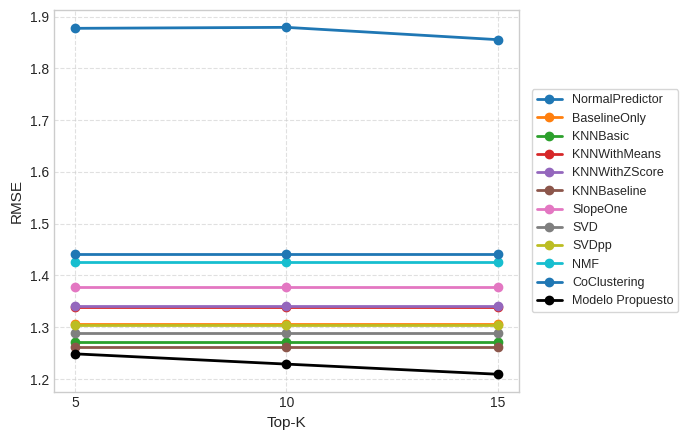

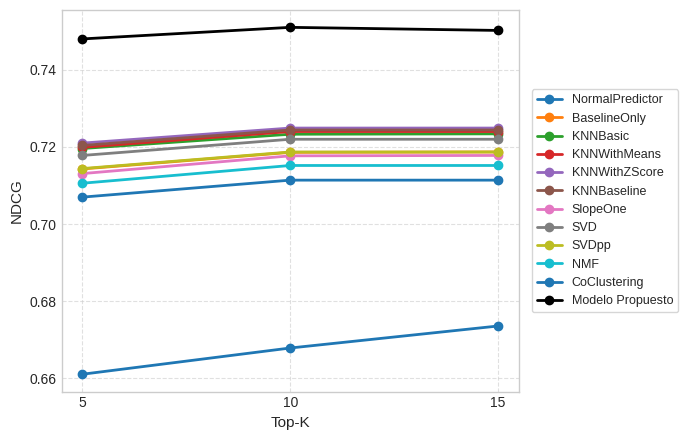

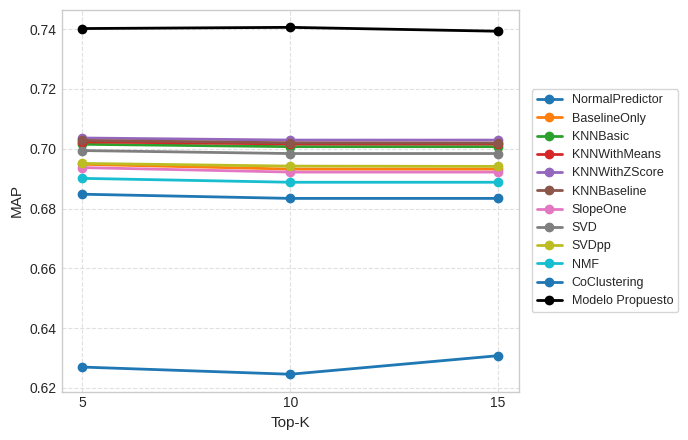

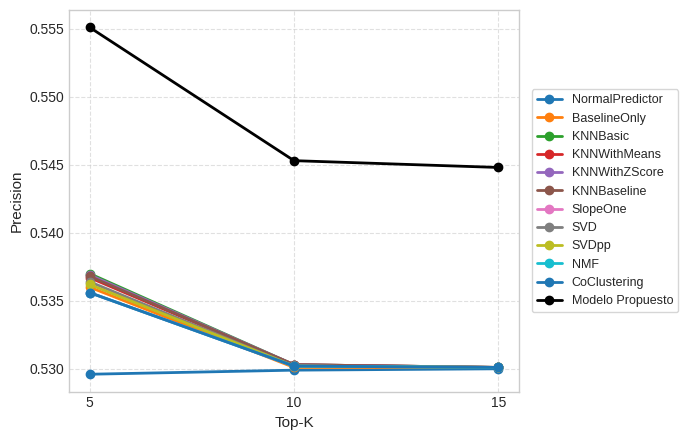

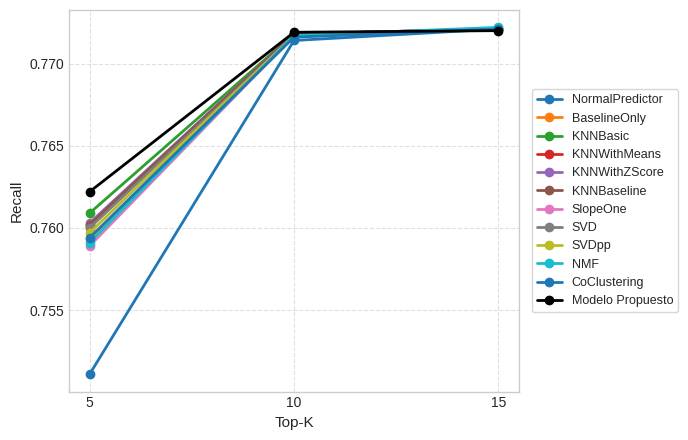

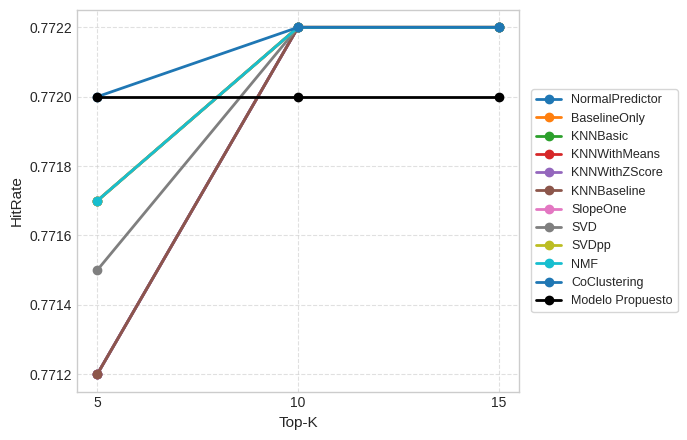

In [ ]:
DATASET = "itm"
METRIC = "F1"

dfs = []
for i in [5, 10, 15]:
  df = get_models_comparision(i, DATASET)
  df.rename(index={
      f"F1@{i}": "F1",
      f"NDCG@{i}": "NDCG",
      f"MAP@{i}": "MAP",
      f"MRR@{i}": "MRR",
      f"Precision@{i}": "Precision",
      f"Recall@{i}": "Recall",
      f"HitRate@{i}": "HitRate"
  }, inplace=True)
  dfs.append(df)

# print(f"{METRIC} TOP-5 {DATASET}")
# print(dfs[0].loc[METRIC])
# print(f"\n{METRIC} TOP-10 {DATASET}")
# print(dfs[1].loc[METRIC])
# print(f"\n{METRIC} TOP-15 {DATASET}")
# print(dfs[2].loc[METRIC])

metrics = [
    # "MSE",
    "RMSE",
    "NDCG",
    "MAP",
    # "MRR",
    "Precision",
    "Recall",
    "HitRate"
]

algos = [
    "NormalPredictor",
    "BaselineOnly",
    "KNNBasic",
    "KNNWithMeans",
    "KNNWithZScore",
    "KNNBaseline",
    "SVD",
    "SVDpp",
    "NMF",
    "CoClustering",
    "SlopeOne",
    "Modelo Propuesto"
]

for metric in metrics:
  plot_models_line(
      dfs[0], dfs[1], dfs[2],
      metric=metric,
      dataset=DATASET,
      # show_cols=algos
  )
  print()